<a href="https://colab.research.google.com/github/Mamedova-S/VKR_Mamedova/blob/main/src/audio/cnn_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from __future__ import print_function
import pandas as pd
import boto
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:

prefix = '/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/'

df_train = pd.read_csv(prefix+'train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv(prefix+'dev_split_Depression_AVEC2017.csv')
df_dev = pd.concat([df_train, df_test], axis=0)

In [ ]:
K.set_image_data_format('channels_first')
np.random.seed(15) 

In [ ]:
def preprocess(X_train, X_test):

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train = np.array([(X - X.min()) / (X.max() - X.min()) for X in X_train])
    X_test = np.array([(X - X.min()) / (X.max() - X.min()) for X in X_test])
    return X_train, X_test

In [ ]:
from keras.utils import np_utils

def prep_train_test(X_train, y_train, X_test, y_test, nb_classes):

    print('Train on {} samples, validate on {}'.format(X_train.shape[0],
                                                       X_test.shape[0]))
    X_train, X_test = preprocess(X_train, X_test)
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    return X_train, X_test, Y_train, Y_test

In [ ]:
def keras_img_prep(X_train, X_test, img_dep, img_rows, img_cols):

    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    return X_train, X_test, input_shape


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models,preprocessing,regularizers,callbacks
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model

def cnn(X_train, y_train, X_test, y_test, batch_size,
        nb_classes, epochs, input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', strides=1,
                     input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
    model.add(Conv2D(32, (1, 3), padding='valid', strides=1,
              input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])


    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        verbose=1, validation_data=(X_test, y_test))
    
    # score_train = model.evaluate(X_train, y_train, verbose=0)
    # print('Train accuracy:', score_train[1])
    # score_test = model.evaluate(X_test, y_test, verbose=0)
    # print('Test accuracy:', score_test[1])

    return model, history

In [ ]:
def model_performance(model, X_train, X_test, y_train, y_test):
    y_test_pred = np.argmax(model.predict(X_test), axis=1)
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_test_pred_proba = model.predict(X_test)
    y_train_pred_proba = model.predict(X_train)
    y_test_1d = y_test[:, 1]
    conf_matrix = standard_confusion_matrix(y_test_1d, y_test_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    return y_train_pred, y_test_pred, y_train_pred_proba, \
        y_test_pred_proba, conf_matrix

In [ ]:
def standard_confusion_matrix(y_test, y_test_pred):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_test, y_test_pred)
    return np.array([[tp, fp], [fn, tn]])

In [ ]:

from keras.optimizers import Adam

if __name__ == '__main__':
    prefix="/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Dataset/Randomly_Sampled_Data/"
    prefix1="/content/drive/MyDrive/Colab Notebooks/VKR_Depression/Experiments/"
    print('Retrieving from drive...')
    X_train = np.load(prefix+"train_samples.npz")
    y_train = np.load(prefix+'train_labels.npz')
    X_test = np.load(prefix+'test_samples.npz')
    y_test = np.load(prefix+'test_labels.npz')

    X_train, y_train, X_test, y_test = \
        X_train['arr_0'], y_train['arr_0'], X_test['arr_0'], y_test['arr_0']

    # CNN parameters
    batch_size = 16
    nb_classes = 2
    epochs = 200

    X_train, X_test, y_train, y_test = prep_train_test(X_train, y_train,
                                                       X_test, y_test,
                                                       nb_classes=nb_classes)
    img_rows, img_cols, img_depth = X_train.shape[1], X_train.shape[2], 1
    X_train, X_test, input_shape = keras_img_prep(X_train, X_test, img_depth,
                                                  img_rows, img_cols)

    model, history = cnn(X_train, y_train, X_test, y_test, batch_size,
                         nb_classes, epochs, input_shape)

    y_train_pred, y_test_pred, y_train_pred_proba, y_test_pred_proba, \
        conf_matrix = model_performance(model, X_train, X_test, y_train, y_test)
   
    model_name = prefix1+'cnn_audio1.h5'
    model.save(model_name)
 

Epoch 1/200
263/263 [==============================] - 2s 5ms/step - loss: 4.3078 - accuracy: 0.1561 - val_loss: 1.6904 - val_accuracy: 0.3720
Epoch 2/200
263/263 [==============================] - 1s 4ms/step - loss: 2.3005 - accuracy: 0.2846 - val_loss: 1.3724 - val_accuracy: 0.5538
Epoch 3/200
263/263 [==============================] - 1s 4ms/step - loss: 1.6948 - accuracy: 0.4178 - val_loss: 1.2759 - val_accuracy: 0.6032
Epoch 4/200
263/263 [==============================] - 1s 4ms/step - loss: 1.4051 - accuracy: 0.5204 - val_loss: 1.1733 - val_accuracy: 0.6080
Epoch 5/200
263/263 [==============================] - 1s 4ms/step - loss: 1.3126 - accuracy: 0.5417 - val_loss: 1.1266 - val_accuracy: 0.6327
Epoch 6/200
263/263 [==============================] - 1s 4ms/step - loss: 1.1941 - accuracy: 0.5959 - val_loss: 1.0800 - val_accuracy: 0.6556
Epoch 7/200
263/263 [==============================] - 1s 4ms/step - loss: 1.1383 - accuracy: 0.6046 - val_loss: 1.0233 - val_accuracy: 0.6755

Epoch 58/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4483 - accuracy: 0.8399 - val_loss: 0.5216 - val_accuracy: 0.8126
Epoch 59/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4514 - accuracy: 0.8406 - val_loss: 0.5148 - val_accuracy: 0.8116
Epoch 60/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4909 - accuracy: 0.8258 - val_loss: 0.4996 - val_accuracy: 0.8268
Epoch 61/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4563 - accuracy: 0.8301 - val_loss: 0.5178 - val_accuracy: 0.8183
Epoch 62/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4576 - accuracy: 0.8411 - val_loss: 0.4969 - val_accuracy: 0.8297
Epoch 63/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8529 - val_loss: 0.5043 - val_accuracy: 0.8202
Epoch 64/200
263/263 [==============================] - 1s 5ms/step - loss: 0.4275 - accuracy: 0.8434 - val_loss: 0.4969 - val_accuracy:

Epoch 115/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3190 - accuracy: 0.8863 - val_loss: 0.4337 - val_accuracy: 0.8382
Epoch 116/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3231 - accuracy: 0.8836 - val_loss: 0.4389 - val_accuracy: 0.8402
Epoch 117/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3089 - accuracy: 0.8888 - val_loss: 0.4261 - val_accuracy: 0.8506
Epoch 118/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3020 - accuracy: 0.9011 - val_loss: 0.4385 - val_accuracy: 0.8535
Epoch 119/200
263/263 [==============================] - 1s 5ms/step - loss: 0.3137 - accuracy: 0.8837 - val_loss: 0.4302 - val_accuracy: 0.8430
Epoch 120/200
263/263 [==============================] - 1s 5ms/step - loss: 0.2822 - accuracy: 0.8990 - val_loss: 0.4247 - val_accuracy: 0.8544
Epoch 121/200
263/263 [==============================] - 1s 5ms/step - loss: 0.2973 - accuracy: 0.8901 - val_loss: 0.4330 - val_ac

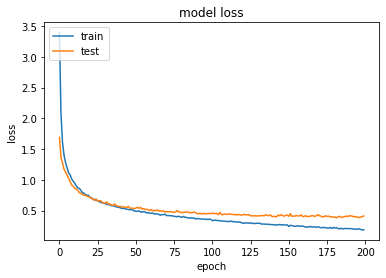

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('cnn_loss.png') 
plt.show()

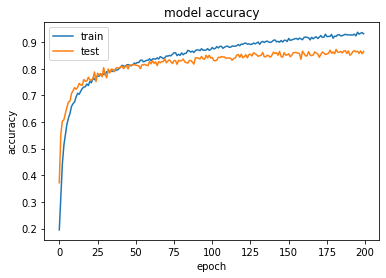

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()